<center><h1 style="font-family: cambria;font-size:40px;"> Fourier Transform in MRI:<br> Mathematical theory and related artifacts</h1></center>

In [19]:
# Importing the libraries/functions required to run this notebook

import copy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
matplotlib.rc('image', cmap='gray') # Set default image colormap as gray
import numpy as np

from numpy.fft import *
from utils.fourier_widgets import *

# Introduction

## Who is Joseph Fourier ?

**Jean Baptiste Joseph Fourier** (1768-1830) was a **french mathematician and physicist** that notably investigated the Fourier Series theorem that states that ***any signal can be decomposed into a sum of sinusoidal sub-signals, each having its own frequency, magnitude and phase***. This property later became one of the most fundamental tool for signal processing, especially in Magnetic Resonance Imaging where this duality between the spatial evolution of a signal and its frequency/magnitude/phase components is the bedrock of the image reconstruction process.

<figure><center>
  <img src="./utils/images/Joseph_Fourier.jpg" alt="Joseph Fourier" style="width:20%">
    <figcaption> <i>Joseph Fourier (1768 - 1830)</i> </figcaption></center>
</figure>


Fourier is notably known for: 
- Proposing the **Fourier number** (Heat transfer)
- Discovering the **Fourier series** (Mathematics)
- Proposing the **Fourier Transform** formulas (Mathematics)
- Establishing the **Fourier's law of conduction** (Heat transfer)
- Proposing the **Fourier-Motzkin elimination** algorithm (Mathematics)
- Dicscovering the **greenhouse effect** (Heat transfer)

## Fourier series: everything is sinusoidal!
As previously mentionned, Fourier demonstrated that any signal can be decomposed into a sum of sinusoidal sub-signals, each having its own **frequency**, **magnitude** and **phase**. 

The interactive animation below shows how a square signal $s(t)$ can be decomposed in many sinusoids of different frequencies and amplitudes (in this particular example, they all have the same phase):

In [39]:
# Run this cell to load the widget
square_signal_decomposition_widget()

Loading BokehJS ...

As we can see on the animation, **the more sinusoids we use, the better the square signal is approximated**. This means that perfectly aproaching a square signal would require an infinity of sinusoids, which is obviously impossible to reach in practice. But we will later see that we can still get a good approximation with a finite number of sinusoids.

Similarly, **any random signal can be approximated by summing a sufficient amount of sinusoids** (summing the same number of sinusoids as the number of samples in the signal should result in an exact reproduction of the signal). The interactive animation below illustrates this with a randomly generated signal composed of 50 samples:

In [38]:
# Run this cell to load the widget
random_signal_decomposition_widget()

Loading BokehJS ...

We indeed see that summing 50 sinusoids results in a perfect representation of the original signal with 50 samples.

Note that the first sinusoid is a constant signal (a sin function with 0Hz frequency): It is the $0Hz$ component of the signal and **its value is the mean of the signal**.

The sinusoids with the highest frequencies have sharp edges because they are sampled with the same frequency as the signal (they have the same number of points): we don't have any information between the samples. This will be further discussed in the *Aliasing and Nyquist-Shannon theorem* section.

## The Fourier Domain: just another way of seeing things

In the Fourier Domain, **each point represents a sinusoidal component of the signal**. 

The order in which the sinusoids are represented in the Fourier domain is based on the frequency, this is why we sometimes call it the **Frequency domain**.

Two different ways of representing the Fourier Domain are commonly used:

- The **non-shifted Fourier Domain**: Ranging from low to high frequencies ($Range: [0, F_s]$, $F_s$ being the sampling frequency of the signal),
- The **shifted Fourier Domain**: High frequencies are located on the edges of the Fourier Domain, and the 0Hz component (mean) of the signal is represented in the center. ($Range: [-\frac{F_s}{2}, \frac{F_s}{2}]$)

The Fourier Domain is thus a mathematical representation of a signal in terms of **frequency**. It has a **magnitude** component and a **phase** component, it is thus a **complex domain**. We will see later what kind of information about the signal is respectively held by each component.

The highest frequency represented corresponds to the sampling frequency of the signal. 

Sometimes, the Fourier Domain is referred to as the **k-space** (we will later see why). This is particularly true in the MRI community.

### Fourier transform

The Fourier Transform is a very powerful mathematical tool that allows us to go back and forth between the spatial (or temporal) domain and the frequency domain (Fourier Domain). In other words, it switches between the spatial representation of a signal (i.e. an image), and the frequency/phase representation of the signal. These two representations are equivalent, as they relate to the same signal, but they have different utilities. For example, the Fourier domain will come handy when we need to visualize the main frequencies that compose a signal, in order to filter it for example.
<br><br>
<figure><center>
  <img src="./utils/images/1D_shift.jpg" alt="Time and frequency domains" style="width:95%">
    <figcaption> <i>Time and frequency domains</i> </figcaption></center>
</figure>

### Continuous  Fourier Transform

For a continuous signal $s$ (infinite number of points), its Fourier transform $S$ will be given by the following formula:

$\large S(f) = \int\limits_{-\infty}^{\infty}s(t) e^{-i2\pi ft}dt$

Reciprocally, the signal $s$ can be retrieved from $S$ according to the **inverse Fourier Transform** formula:

$\large s(t) = \int\limits_{-\infty}^{\infty}S(f) e^{i2\pi ft}df$


### Discrete Fourier Transform

For a discrete signal $s$ composed of $N$ samples, a similar formula can be written down as:

$\large S(k) = \sum\limits_{n=0}^{N-1} s(n)e^{-i2\pi \frac{k}{N}n}, \hspace{5mm} for \hspace{5mm} 0 \leqslant k \ < N $

The discrete inverse Fourier Transform formula will then be:

$\large s(n) = \frac{1}{N}\sum\limits_{k=0}^{N-1} S(k)e^{i2\pi \frac{n}{N}k} $

The most common algorithm to compute the Fourier Transforms of discrete signals is the [***fast Fourier Transform***](https://en.wikipedia.org/wiki/Fast_Fourier_transform), developped by *Cooley* and *Tukey* in 1965 and usually reffered to as **FFT**. In this notebook, we will use a Python implementation of this algorithm available in the `numpy.fft` package.

For a real signal $s$, $S$ will be complex, with both magnitude and phase components being of interest for the processing of the signal: 
- The phase relates to the position of the different sinusoids composing the image,
- The magnitude relates to the intensity of each of this sinusoids.

In order to better visualize how all of this works, we will use the example of a signal composed of 3 sinusoids with different amplitudes, frequencies and phases:
<br><br>

<center>$\large s_1=\sin(2\pi t), \hspace{5mm} s_2=\dfrac{\sin(20 \pi  t +\frac{\pi}{2})}{3},\hspace{5mm} s_3 = \dfrac{\sin(10 \pi  t +\pi)}{5}$</center>

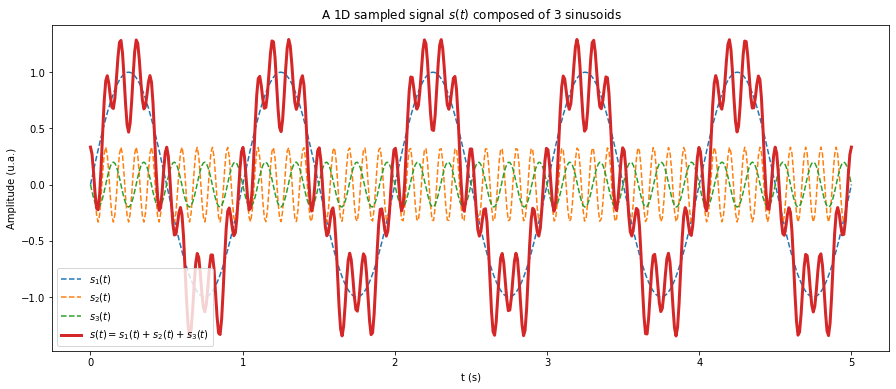

In [22]:
Fs = 100                                     # Sampling frequency (Hz)
t_0 = 0                                      # Sampling starting time (s)
t_max = 5                                    # Sampling ending time (s)
nb_samples = (t_max - t_0)* Fs               # Number of samples (=500)
t = np.linspace(t_0, t_max, nb_samples)      # Creation of the temporal vector (duration: 5 s ; sampling frequency: 100Hz)

s1 = np.sin(t * 2 * np.pi)                   # Signal s1 --> Amplitude: 1   a.u. ; Frequency: 1 Hz ; Phase: 0 rad
s2 = np.sin(t * 20 * np.pi + np.pi / 2) / 3  # Signal s2 --> Amplitude: 1/3 a.u. ; Frequency: 10  Hz ; Phase: pi/2 rad
s3 = np.sin(t * 10 * np.pi + np.pi) / 5       # Signal s3 --> Amplitude: 1/5 a.u. ; Frequency: 5 Hz ; Phase: pi rad
s = s1+s2+s3                                 # Signal s (sum of all signals above)

plt.figure(figsize=[15,6])
plt.plot(t, s1, '--'); plt.plot(t, s2, '--'); plt.plot(t, s3, '--'); plt.plot(t, s, lw=3); plt.title("A 1D sampled signal $s(t)$ composed of 3 sinusoids"); plt.legend(["$s_1(t)$", "$s_2(t)$", "$s_3(t)$", "$s(t) = s_1(t)+s_2(t)+s_3(t)$"]); plt.xlabel("t (s)"); plt.ylabel("Amplitude (u.a.)");
plt.show()

We will now see what the signal above looks like in the Fourier domain.

### Magnitude spectrum

The magnitude spectrum represents the amplitudes associated to each sinusoid component of the signal.

- The 0 Hz component of the magnitude spectrum represents the mean of the signal (a constant signal will only have one peak at 0Hz),
- The magnitude located at some frequency is the amplitude of the corresponding sinusoid,
- If a frequency is not present in the original signal, the corresponding magnitude value in the Fourier Domain will simply be null.

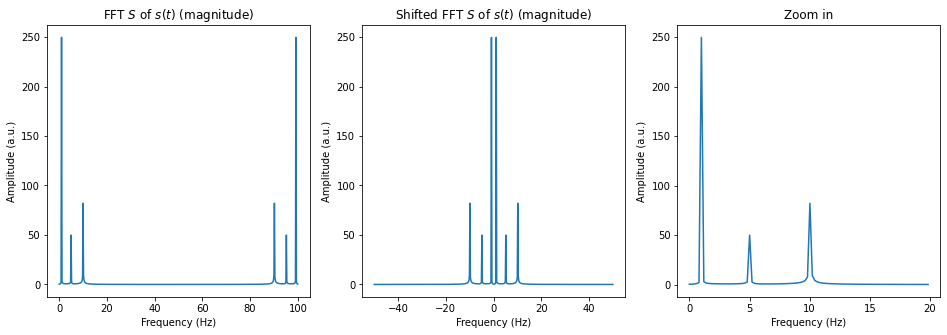

In [23]:
plt.figure(figsize=[16,5])
plt.subplot(131); plt.plot(np.linspace(0, Fs, nb_samples),np.abs(fft(s))); plt.title("FFT $S$ of $s(t)$ (magnitude)"); plt.xlabel("Frequency (Hz)"); plt.ylabel("Amplitude (a.u.)")
plt.subplot(132); plt.plot(np.linspace(-Fs/2, Fs/2, nb_samples), np.abs(fftshift(fft(s)))); plt.title("Shifted FFT $S$ of $s(t)$ (magnitude)"); plt.xlabel("Frequency (Hz)"); plt.ylabel("Amplitude (a.u.)")
plt.subplot(133); plt.plot(np.linspace(0, Fs, nb_samples)[:100], np.abs(fft(s))[:100]); plt.title("Zoom in"); plt.xlabel("Frequency (Hz)"); plt.ylabel("Amplitude (a.u.)")
plt.show()

We see here that we obtain 3 symmetrical peaks. In the shifted Fourier Domain, the **magnitude is an even function**. The reasons behind this symmetry will be investigated later, but it is important to notice that shifting the Fourier spectrum results in switching its second and first halves. 

For now, we are more interested in the fact that the 3 peaks are located at 3 specific frequencies: $1Hz$, $5Hz$ and $10Hz$.
The frequencies correspond to the frequencies of $s_1$, $s_3$ and $s_2$ respectively.
The relative amplitudes of the peaks also correspond to $1$, $\frac{1}{3}$ and $\frac{1}{5}$ as expected.

### Phase spectrum

For any frequency composing the signal, the corresponding phase value will represent the moment the sinusoid was "fired out" compare to a null-phase reference. It is thus very important to know the phase component of the Fourier representation of a signal.

- The phase ranges from $-\pi$ to $\pi$,
- The phase relates to the position of a sinusoid in the signal.

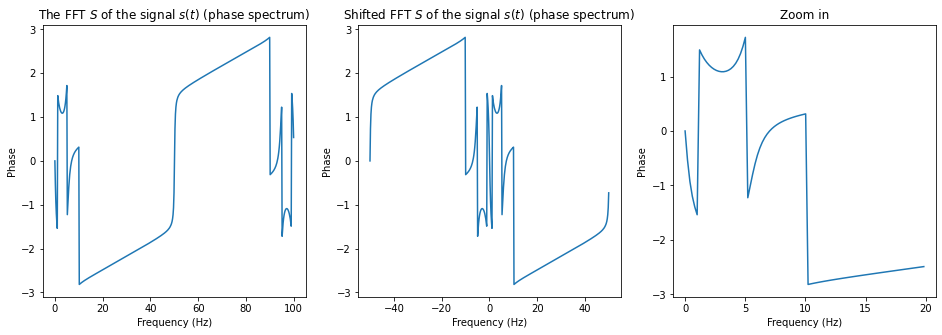

In [24]:
plt.figure(figsize=[16,5])
plt.subplot(131)
plt.plot(np.linspace(0, Fs, nb_samples),np.angle(fft(s)))
plt.title("The FFT $S$ of the signal $s(t)$ (phase spectrum)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase")

plt.subplot(132)
plt.plot(np.linspace(-Fs/2, Fs/2, nb_samples), np.angle(fftshift(fft(s))))
plt.title("Shifted FFT $S$ of the signal $s(t)$ (phase spectrum)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase")

plt.subplot(133)
plt.plot(np.linspace(0, Fs, nb_samples)[:100], np.angle(fft(s))[:100])
plt.title("Zoom in")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase")
plt.show()

The phase spectrum is harder to understand than the magnitude spectrum, but it is interesting to notice that abrupt phase changes occur at the frequencies composing our signal. In the shifted Fourier Domain, it is also important to notice that **the phase is an odd function**.

**Notes about shifting the Fourier domain:** 

- The **fftshift** function is used to pass **from unshifted to shifted** Fourier domain.

- The **ifftshift** function is used to pass **from shifted to unshifted** Fourier domain.

For signals with an even number of samples, these 2 functions do exactly the same thing and interverting them does no harm. For signals with an odd number of samples, they should be used cautiously as some data might be misinterpreted in the process.

### Aliasing and Nyquist-Shannon theorem

We have seen that the Fourier Domain ranges from $0Hz$ to $F_s$, but what happens if some frequencies composing the signal are larger than the sampling frequency ?

The animation below shows how the sampling frequency affects the acquisition of a $5Hz$ signal: 

In [37]:
# Run this cell to load the widget
aliasing_widget()

Loading BokehJS ...

We notice here that for $F_s > 10Hz$, the sampled signal progressively diverges from the original one as $F_s$ decreases, but we can still correctly estimate the original frequency. 

With a sampling frequency of $10Hz$ and lower, we completely miss some signal inversions. This means that we will not be able to correctly estimate the frequency of the original signal: **we will alias the true frequency of the signal for a lower one**, this is what we call **aliasing**.

In order to avoid the aliasing phenomenon, Harry Nyquist and Claude Shannon stated that a signal should be acquired with a sampling frequency **at least twice as large as the maximum frequency comprised in the signal** ($F_{max}$), resulting in at least 2 samples per period, which is enough to not miss any inversion.

<br><center style="font-family:Knuth; font-size:25px;">  Nyquist-Shannon sampling condition: $ F_s > 2F_{max}$ </center><br>

**Note:** At $F_s = 10Hz$, we observe a particular case where the samples are acquired at exactly every time the signal is null, resulting in a $0Hz$ (constant) sampled signal. This is a very unlucky situation (acquiring the samples a few ms later would have been enough to estimate the original frequency). This is why $F_s$ must be **strictly larger** than $2F_{max}$ in order to always avoid aliasing.

### Aliasing in the Fourier domain

As we previously saw, the frequencies are repeated in the magnitude Fourier domain. This is due to a specific property of the Fourier domain: **It is theoretically infinite and repeats every $F_s$** (this is why the second part of the non-shifted Fourier domain can be shifted before the first half, resulting in the shifted representation).

If $F_s$ does not respect the Nyquist-Shannon condition, the second occurence of the Fourier domain will overlap with the first one and this will result in a misinterpretation of the frequency content of the signal: we are once again in the presence of aliasing.

# 2D Fourier transform of images

For 2-dimensionnal $M\times N$ signal (e.g. images), the discrete Fourier Transform formula becomes:

$\large S(k, l) = \sum\limits_{m=0}^{M-1}\sum\limits_{n=0}^{N-1} s(m, n)e^{-i2\pi ( \,\frac{mk}{M}+\frac{nl}{N}) \,}, \hspace{5mm} for \hspace{5mm} 0 \leqslant k \ < M,\hspace{5mm} 0 \leqslant l \ < N $

The **2D inverse Fourier transform** is given by:

$\large s(m, n) = \frac{1}{M*N}\sum\limits_{m=0}^{M-1}\sum\limits_{n=0}^{N-1} S(k, l)e^{i2\pi ( \,\frac{mk}{M}+\frac{nl}{N})}$

From these formulas, we see that the 2D Fourier transform of an image will have the same size as the image, and will once again be complex.

In 2D, the shifted/unshifted Fourier domains relate as follows: 
<figure><center>
  <img src="./utils/images/2D_shift.jpg" alt="Shifting in the 2D Fourier domain" style="width:80%">
    <figcaption> <i>Shifting in the 2D Fourier domain</i> </figcaption></center>
</figure>

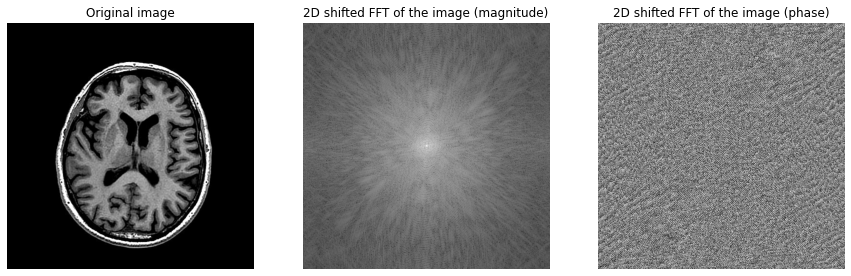

In [26]:
brain_image = mpimg.imread('./utils/images/brain_MRI.jpg') # Loading the MR image of the brain that will serve as an example
brain_FFT = fft2(brain_image) # For images, we use fft2(), the 2D equivalent of fft()

plt.figure(figsize=[15,7])
plt.subplot(131); plt.imshow(brain_image); plt.title("Original image"); plt.axis('off')
plt.subplot(132); plt.imshow(np.log(np.abs(fftshift(brain_FFT)))); plt.title("2D shifted FFT of the image (magnitude)"); plt.axis('off')
plt.subplot(133); plt.imshow(np.angle(brain_FFT)); plt.title("2D shifted FFT of the image (phase)"); plt.axis('off')
plt.show()

### High/low frequency components

Similarly to the 1D case, the 2D shifted Fourier domain has the low frequency values in its middle, and the high frequency values on the edges.

In the 2D Fourier domain:
- The **$0Hz$ frequency** correspond to the **mean intensity** of the image. 

- **Low frequencies** correspond to slowly varying intensities across the image (big objects, light/shadows...).

- **High frequencies** correspond to abrupt intensity variations (small objects, outlines...).



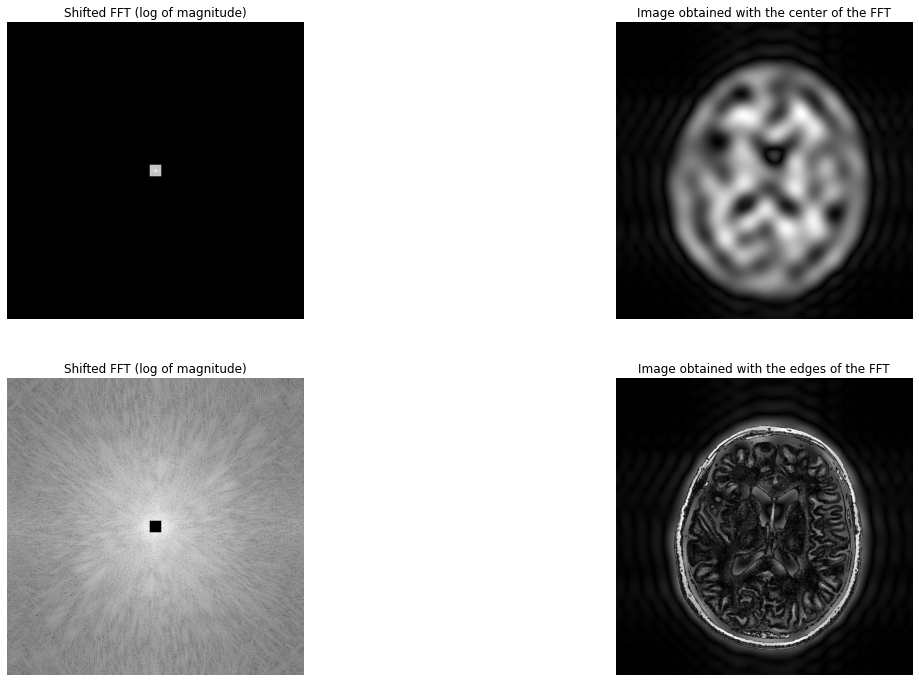

In [27]:
mask_center = np.zeros_like(brain_FFT)  # mask that only keeps the center of the FFT
mask_center[brain_FFT.shape[0]//2-10:brain_FFT.shape[0]//2+10, brain_FFT.shape[1]//2-10:brain_FFT.shape[1]//2+10] = 1
mask_edges = np.ones_like(brain_FFT)-mask_center # mask that only keeps the edges of the FFT

brain_FFT_center = fftshift(brain_FFT)*mask_center # Apply masking to keep center of the FFT
brain_FFT_edges = fftshift(brain_FFT)*mask_edges # Apply masking to keep edges of the FFT

plt.figure(figsize=[20,12])
plt.subplot(221); plt.imshow(np.log(fftshift(np.abs(brain_FFT)))*np.abs(mask_center)); plt.title("Shifted FFT (log of magnitude)"); plt.axis('off')
plt.subplot(222); plt.imshow(np.abs(ifft2(brain_FFT_center))); plt.title("Image obtained with the center of the FFT"); plt.axis('off')
plt.subplot(223); plt.imshow(np.log(fftshift(np.abs(brain_FFT)))*np.abs(mask_edges)); plt.title("Shifted FFT (log of magnitude)"); plt.axis('off')
plt.subplot(224); plt.imshow(np.abs(ifft2(brain_FFT_edges))); plt.title("Image obtained with the edges of the FFT"); plt.axis('off')
plt.show()

On the images above, we observe that removing the edges of the FFT (i.e. keeping the low frequencies) results in a blurry images where only the general shapes can be distinguished. What we did here corresponds to a **low-pass filtering**.

On the contrary, removing the center of the FFT yields a very detailed image with an important loss of intensity. What we did here corresponds to a **high-pass filtering**.

This shows that the Fourier Transform is an interesting tool in order to perform image filtering. Compared to a spatial filtering that requires a 2D convolution of the image with a filtering elements, applying an FFT and filter by an element-wise multiplication will often be a much less computationnaly expensive solution.

## Orientation of the frequencies in the image

In 1D, all sinusoids are along the only axis available, but in 2D, periodic intensity variations can be oriented along any directions as illustrated below:


<img src="./utils/images/stripes.jpg" alt="Stripes with different orientations and frequencies" style="width:60%">

In the Fourier domain, the orientation of all the sinusoids composing the image is given by the angle around the 0Hz component, as shown by the code below:

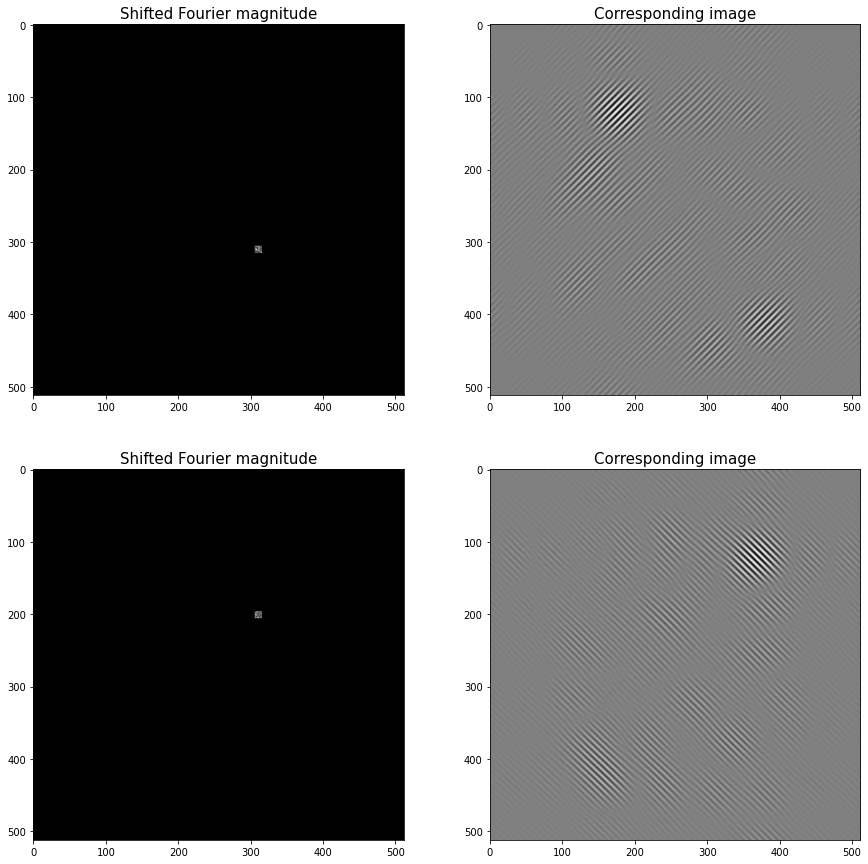

In [28]:
dummy_FFT_1 = np.zeros_like(brain_FFT).astype(complex)
dummy_FFT_1[50:60,50:60] = brain_FFT[50:60,50:60]

dummy_FFT_2 = np.zeros_like(brain_FFT).astype(complex)
dummy_FFT_2[-60:-50,50:60] = brain_FFT[-60:-50,50:60] 

plt.figure(figsize=[15,15])
plt.subplot(221); plt.imshow(np.abs(fftshift(dummy_FFT_1))); plt.title('Shifted Fourier magnitude', fontsize=15)
plt.subplot(222); plt.imshow(np.real(ifft2(dummy_FFT_1))); plt.title('Corresponding image', fontsize=15)
plt.subplot(223); plt.imshow(np.abs(fftshift(dummy_FFT_2))); plt.title('Shifted Fourier magnitude', fontsize=15)
plt.subplot(224); plt.imshow(np.real(ifft2(dummy_FFT_2))); plt.title('Corresponding image', fontsize=15)
plt.show()

The example above shows how, by only keeping values at a certain orientation in the k-space, the resulting image in only composed of stripes perpendicular to that orientation.

### Rotation in the Fourier domain

It is now quite straightforward to understand that rotating the FFT would result in a rotated image:

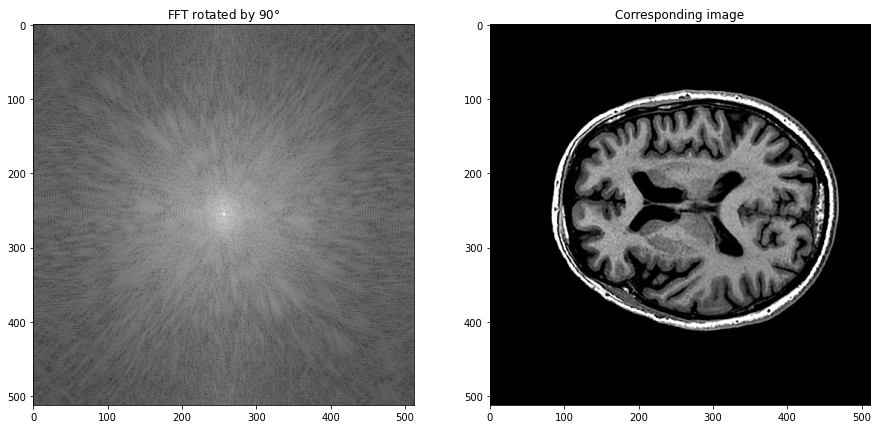

In [29]:
brain_FFT_rotated = np.rot90(brain_FFT)

plt.figure(figsize=[15,7])
plt.subplot(121)
plt.imshow(np.log(np.abs(fftshift(brain_FFT_rotated))))
plt.title("FFT rotated by 90$\degree$")
plt.subplot(122)
plt.imshow(np.abs(ifft2(brain_FFT_rotated)))
plt.title("Corresponding image")
plt.show()

# Why is the Fourier theory so important for MRI ?

In Magnetic Resonance Images, we use **gradient coils** in order to encode the spatial location of the spins in the Fourier Domain. 

## Slice selection

Most of MR acquisitions result in 3D images covering a specific anatomical region of the patient. But the signal is usually acquired on a slice-by-slice basis, and the 2D images are then "stacked" together, resulting in a 3D volume. In order to acquire 2D images at different positions, we need to perform what is referred to as **slice selection**.

<figure><center>
  <div style="display: table;">
      <div style="  float:left ;width: 100%;">
          <img src="./utils/images/slice_selection_comic.jpg" alt="Slice selection comic" style="height:400px">
      </div>
 </div>
 <figcaption> <i>Using slice selection gradients, we can obtain 2D images at different positions in the body. </i> </figcaption></center>
</figure>

The idea behind slice selection is to only excite a "band" of spins in the subject at a time. To do so, a magnetic gradient is applied in the direction of the slices (e.g. $G_z$ for axial images) in order to shift the precession frequencies in the patient. We then use an excitation pulse with a central value $\omega$ and a **finite bandwidth** $\Delta \omega $ in order to only excite the spins located around a certain position along the slice direction, as illustrated by the following figure:

<center>
    <figure>
        <img src="./utils/images/slice_selection.jpg" alt="Herringbone Pattern" style="height:400px">
        <figcaption> <i>Slice selection principle</i> </figcaption>
    </figure>
</center>

On the figure above, two different slices are excited by two excitation pulses with central frequencies of $\omega_1$ and $\omega_2$ respectively. As the slice selective gradient is spatially linear and both excitation pulses have the same bandwidth $\Delta \omega$, the slices 1 and 2 have the same thickness. 

**The central frequency of the excitation pulse relates to the position of the slice:**

<br>

<center> $\large \omega = \gamma B = \gamma G_zz$ </center>

**The slice thickness depends on the gradient strength and the RF pulse bandwidth:**

<br>

<center> $\large \Delta z = \frac{\Delta\omega}{\gamma G_z}$ </center>


It is thus possible to change the slice thickness by playing with the strength of the slice selective gradient or the excitation pulse bandwidth, as shown below:

<center>
    <div style="display: table;">
        <div style="  float: left;width: 50%;">
    <figure>
        <img src="./utils/images/slice_selection_gradient_strength.jpg" alt="Corduroy (textile)" style="height:300px">
        <figcaption> <i>Effect of the gradient strength on the slice thickness</i> </figcaption>
    </figure>
        </div>
        <div style="  float: left;width: 50%;">
    <figure>
        <img src="./utils/images/slice_selection_pulse_bandwidth.jpg" alt="Corduroy (textile)" style="height:300px">
        <figcaption> <i>Effect of the RF pulse bandwidth on the slice thickness</i> </figcaption>
    </figure>
        </div>
    </div>
</center>
<center>

</center>

Without any slice selection gradient, all slices would be excited at the same time and it would be impossible to separate the signals coming from different slices. 

**Notes:** 
- The ideal slice profile is a rectangle function, so the corresponding RF pulse must be a sync function (the fourier transform of a rectangle function is a sync function).
- The RF bandwith depends on the shape and duration of the RF pulse.
- The application of a slice selective gradient induces a dephasing of the spins in the slice, requiring a **slice refocusing gradient** (opposite to the slice selective gradient and with half its area).

## K-space

Now that we have seen how we can spatially select a slice to image, we will see how the Fourier theory intervenes in the image reconstruction process.

The spins rotate arround the main magnetic field $B_0$ of the scanner at a certain frequency $w_0$ (**Larmor Frequency**). The larmor frequency is related to the $B_0$ strength according to the formula below: 
<center>$\omega_0 = \gamma B_0$</center>

When a slice is excited, all its spins are tipped in the transverse plane and progressively come back to there original position along the $B_0$ field, emitting a decaying RF signal called **Free Induction Decay (FID)**. 

At this point, we cannot obtain an image because the FID does not carry any spatial information (except that it comes from the selected slice). 

The measured signal can be described as follows: 

<br> 

<center> $\large S(t) = \iint\limits_{-\infty}^{\infty}h(x,y)e^{-i\omega_0t}dxdy$ </center> 

$h(x,y)$ is the image we seek to reconstruct and its Fourier transform $H(u, v)$ is thus described by: 

<br>

<center> $\large H(u, v) = \iint\limits_{-\infty}^{\infty}h(x,y)e^{-i2\pi ux}e^{-i2\pi vy}dxdy$ </center>

We see that the formulas describind $S(t)$ and $H(u, v)$ are relatively close. By finding a way to convert $e^{-i\omega_0t}$ into $e^{-i2\pi ux}e^{-i2\pi vy}$ the image $h(x,y)$ could be reconstructed by applying an inverse Fourier transform the the measured signal $S(t)$.

This can be achieved by playing with gradient pulses in the slice plane (e.g. $G_x$ and $G_y$ for axial imaging), and we will see how this works.


### Why the letter "k"

During the last centuries, the letter $k$ as often be used in different scientific fields (acoustics, mechanics, electromagnetism...) to refer to the spatial frequency of waves. In the MR community, it became widely used during the 1990s.

A wave is mainly characterized by its wavelength $\lambda$ which is the distance between two successive peaks of the wave. The letter $k$ simply refers to the **wavenumber** of the wave, which is given by $k = \frac{1}{\lambda}$. 

**$k$ is thus the number of waves per unit distance**,  meaning that a large $k$ value will correspond to a high frequency, and a small $k$ value will correspond to a low frequency. This is why we can use k as a variable in the frequency domain (Fourier domain), and why we can call it **k-space**.

For this reason, the formula describing $H(u, v)$, $u$ and $v$ are usually replaced with $k_x$ and $k_y$ as follows:

<br>

<center> $\large H(u, v) = \iint\limits_{-\infty}^{\infty}h(x,y)e^{-i2\pi k_xx}e^{-i2\pi k_yy}dxdy$ </center>

## Frequency encoding


By adding a spatial gradient to the $B_0$ field, the spins' rotation speed will spatially vary: **each frequency composing the measured signal relates to a specific point in space**. This process is called **frequency encoding**.

If frequency encoding is applied along the x-axis, the measured signal is described by: 

<br> 

\begin{equation} \large
\begin{split} 
S(t) & = \iint\limits_{-\infty}^{\infty}h(x,y)e^{-i\gamma(B_0t+G_xt_xx)}dxdy \\
 & = e^{-i\gamma B_0t}\iint\limits_{-\infty}^{\infty}h(x,y)e^{-i\gamma G_xt_xx}dxdy
\end{split}
\end{equation}

## Phase encoding

But this frequency encoding only allows for a frequency variation along one direction (if we do the same thing in 2 directions, spins at different locations might precess at the same speed and the signals they emit will be undistinguishable). For this reason, the position along a second axis does not depend on the frequency, but on the phase of the spins that can also be controlled using magnetic gradients: that is the **phase encoding**.

If phase encoding is applied along the y-axis, the measured signal is described by: 

<br> 

<center> $\large S(t) = e^{-i\gamma B_0t}\iint\limits_{-\infty}^{\infty}h(x,y)e^{-i\gamma G_xt_xx}e^{-i\gamma G_yt_yy)}dxdy$ </center>

After demodulation by the Larmor frequency, we have: 

<br> 
<center> $\large S(t) = H(\frac{\gamma}{2\pi}G_xt_x, \frac{\gamma}{2\pi}G_xt_x) = \iint\limits_{-\infty}^{\infty}h(x,y)e^{-i\gamma G_xt_xx}e^{-i\gamma G_yt_yy)}dxdy$ </center>


Writing $k_x = \frac{\gamma}{2\pi}G_xt_x$ and $k_y = \frac{\gamma}{2\pi}G_yt_y$, we obtain:

<br>

<center> $\large S(t) = H(k_x, k_y) = \iint\limits_{-\infty}^{\infty}h(x,y)e^{-i2\pi k_xx}e^{-i2\pi k_yy)}dxdy$ </center>

These two encoding processes allow for a primordial aspect of MR imaging: **the signal measured during an MRI scan corresponds to the k-space (or Fourier space) of the final image**.

The image can thus obtained by performing an inverse Fourier transform on the acquired k-space.


We will now show how this property might affect the MR images by presenting the different artifact that might arise due to the Fourier relation between the signal and the final image.


# Fourier related MRI artifacts

## Central Point Artifact

A bright spot appears at the center of the image because a constant offset has been added to the measured k-space (the inverse Fourier transform of a uniform signal is a point at the $0Hz$ location).

<br>
<figure><center>
  <div style="display: table;">
      <div style="  float:left ;width: 50%;">
          <img src="./utils/images/central_point1.jpg" alt="Central Point example 1" style="height:300px">
      </div>
      <div style="  float: left;width: 50%;">
          <img src="./utils/images/central_point2.jpg" alt="Central Point example 2" style="height:300px">
      </div>
 </div>
 <figcaption> <i>Examples of central point artifacts</i> </figcaption></center>
</figure>

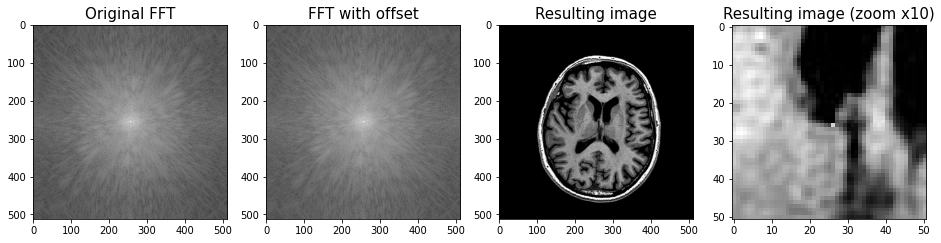

In [30]:
FFT_offset = fft2(ifftshift(brain_image))+0.00001*brain_FFT.max() # The offset added to the FFT is half of its maximum value
brain_central_point = np.abs(fftshift(ifft2(FFT_offset)))

plt.figure(figsize=[16,5])
plt.subplot(141)
plt.imshow(np.log(np.abs(fftshift(brain_FFT))))
plt.title('Original FFT', fontsize=15)
plt.subplot(142)
plt.imshow(np.log(np.abs(fftshift(FFT_offset))))
plt.title('FFT with offset', fontsize=15)
plt.subplot(143)
plt.imshow(brain_central_point)
plt.title('Resulting image', fontsize=15)
plt.subplot(144)
plt.imshow(brain_central_point[230:281,230:281])
# plt.imshow(brain_central_point[0:10,0:10])
plt.title('Resulting image (zoom x10)', fontsize=15)
plt.show()

**What should we do to get rid of this central point ?**

- Repeat the acquisition (the offset might be punctual),
- Make sure that the temperature in the scanner and equipment room remains constant for receiver amplifiers,
- Use a software to estimate the DC offset and adjust the k-space data accordingly,
- Recalibrate the receiver chain.

## Clipping artifact
Also known as: **RF overflow artifact**.

This artifact appears when the measured MR signal is too strong to be correctly digitized by the analog-to-digital converter (**high voltage values are clipped out**).

This results in a non uniform intensity across the image, as the high values are usually the one corresponding to the low frequency components of the FT.

<br>
<figure><center>
  <div style="display: table;">
      <div style="  float:left ;width: 50%;">
          <img src="./utils/images/clipping1.jpg" alt="Clipping example 1" style="height:300px">
      </div>
      <div style="  float: left;width: 50%;">
          <img src="./utils/images/clipping2.jpg" alt="lipping example 2" style="height:300px">
      </div>
 </div>
 <figcaption> <i>Examples of clipping artifacts</i> </figcaption></center>
</figure>

The code below simulates this artifact by thresholding the high values present in the Fourier domain:

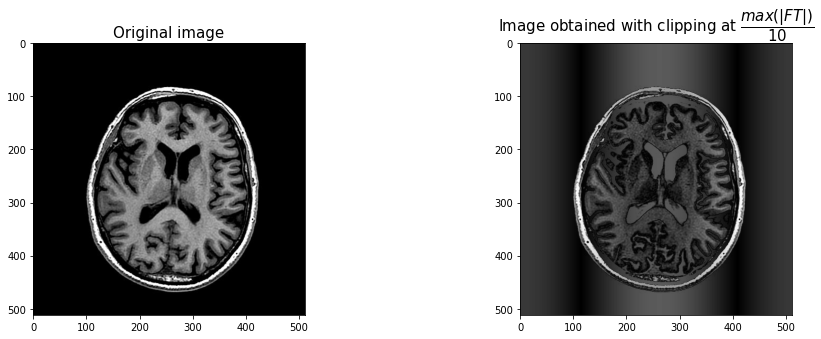

In [31]:
threshold_ADC = 0.5*np.abs(brain_FFT).max() # Clips the FFT with a certain threshold relative to the max magnitude

brain_FFT_clipped = copy.deepcopy(brain_FFT)
brain_FFT_clipped[np.abs(brain_FFT) > threshold_ADC] = threshold_ADC

brain_image_clipped = np.abs(ifft2(brain_FFT_clipped))

plt.figure(figsize=[16,5])
plt.subplot(121); plt.imshow(brain_image); plt.title('Original image', fontsize=15)
plt.subplot(122); plt.imshow(brain_image_clipped); plt.title('Image obtained with clipping at $\dfrac{max(|FT|)}{10}$', fontsize=15)
plt.show()

**How do we get rid of the clipping artifact ?**

Reducing the gain before the Analog-to-Digital Conversion. This artifact is not likely to occur on modern scanners.

## Herringbone artifact

Also known as: **spike artifact**, **crisscross artifact**, or **corduroy artifact**.

<br>
<center>
    <div style="display: table;">
        <div style="  float:left ;width: 33.33%;">
            <figure>
                <img src="./utils/images/Herringbone_pattern.jpg" alt="Herringbone Pattern" style="height:250px">
                <figcaption> <i>Herringbone Pattern</i> </figcaption>
            </figure>
        </div>
        <div style="  float: left;width: 33.33%;">
            <figure>
                <img src="./utils/images/corduroy.jpg" alt="Corduroy (textile)" style="height:250px">
                <figcaption> <i>Corduroy (textile)</i> </figcaption>
            </figure>
        </div>
        <div style="  float: left;width: 33.33%;">
            <figure>
                <img src="./utils/images/spiking.jpg" alt="Spike artefact" style="height:250px">
                <figcaption> <i>Spike artefact</i> </figcaption>
            </figure>
        </div>
    </div>
</center>

The Herringbone artifact **occurs when one or few point(s) in the k-space present an abnormally high value**. These "spikes" might be due to a punctual electrical discharge in the RF coils. This might be induced by the gradient coils or the MR room equipment for example.

When inverse Fourier transforming the k-space, this results in **alterning black and white stripes across the image**. The angle of the stripes will depend on the angular position of the abnormal points in the k-space, and their spacing will depend on how far from the k-space center the point is. These properties are illustrated by the code below:

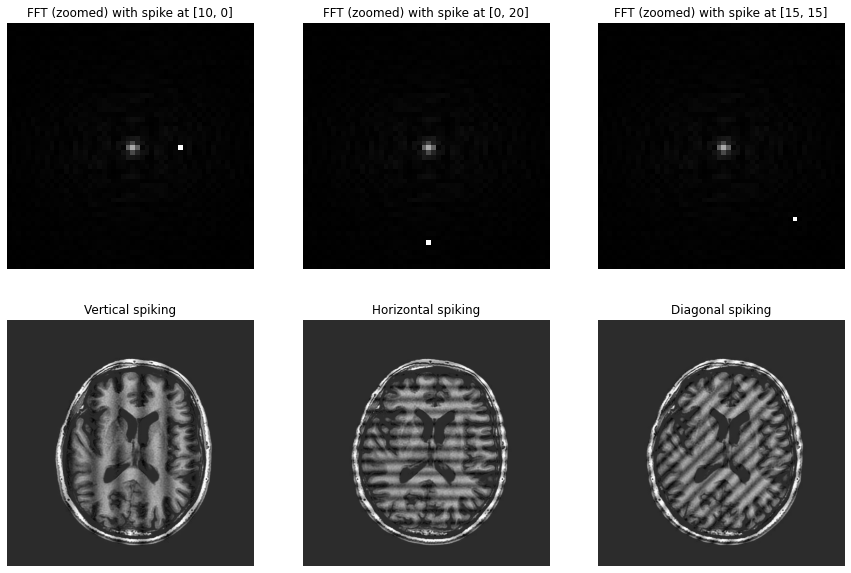

In [32]:
# Vertical Spiking
brain_FFT_vertical_spiking = copy.deepcopy(brain_FFT) # We create a copy of the original FFT
brain_FFT_vertical_spiking[0, 10] = 1.5*brain_FFT.max() # We add a intense spike at [0, 10] in the unshifted Fourier domain
brain_vertical_spiking = np.abs(ifft2(brain_FFT_vertical_spiking)) # iFFT yields an image with a vertical spiking artifact

# Horizontal Spiking
brain_FFT_horizontal_spiking = copy.deepcopy(brain_FFT) # We create a copy of the original FFT
brain_FFT_horizontal_spiking[20, 0] = 1.5 * brain_FFT.max() # We add a intense spike at [20, 0] in the unshifted Fourier domain
brain_horizontal_spiking = np.abs(ifft2(brain_FFT_horizontal_spiking)) # iFFT yields an image with a horizontal spiking artifact

# Diagonal Spiking
brain_FFT_diagonal_spiking = copy.deepcopy(brain_FFT) # We create a copy of the original FFT
brain_FFT_diagonal_spiking[15, 15] = 1.5 * brain_FFT.max() # We add a intense spike at [15, 15] in the unshifted Fourier domain
brain_diagonal_spiking = np.abs(ifft2(brain_FFT_diagonal_spiking)) # iFFT yields an image with a diagonal spiking artifact

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1); plt.imshow(np.abs(fftshift(brain_FFT_vertical_spiking)[230:282,230:282])); plt.title('FFT (zoomed) with spike at [10, 0]'); plt.axis('off')
plt.subplot(2, 3, 2); plt.imshow(np.abs(fftshift(brain_FFT_horizontal_spiking)[230:282,230:282])); plt.title('FFT (zoomed) with spike at [0, 20]'); plt.axis('off')
plt.subplot(2, 3, 3); plt.imshow(np.abs(fftshift(brain_FFT_diagonal_spiking)[230:282,230:282])); plt.title('FFT (zoomed) with spike at [15, 15]'); plt.axis('off')
plt.subplot(2, 3, 4); plt.imshow(brain_vertical_spiking); plt.title('Vertical spiking'); plt.axis('off')
plt.subplot(2, 3, 5); plt.imshow(brain_horizontal_spiking); plt.title('Horizontal spiking'); plt.axis('off')
plt.subplot(2, 3, 6); plt.imshow(brain_diagonal_spiking); plt.title('Diagonal spiking'); plt.axis('off')
plt.show()

**How do we get rid of the Herringbone artifact ?**

The best way to avoid these artifact is to limit the possibilities of induced current in the RF coil (shielding, increasing the distance to other electrical devices...). Spiking artifact are not likely to happen every time so a new acquisition will usually be enough to get rid of them, at the cost of additional scanning time.

**Note:** Similarly, dark strips across the image might also appear when k-space data are missing and fill with zero. This is called a **zero-fill artifact**.

## Wrap-around Artifact

Also known as: **Aliasing** or **Fold-over artifact**.

The wrap-around artifact occurs when the size of the imaged object exceeds the field-of-view (FOV) of the acquisition. The parts of the object located outside the FOV are folded over on the edges of the image.

This happens when high frequency signals coming from outside of the FOV are aliased for frequencies located inside of the FOV (smaller frequencies). The signal coming from the spins outside of the FOV will thus be seen as coming from inside and appear in the image. As we previously saw, aliasing occurs when the sampling-frequency is too low compared to the maximum frequency of the signal.

On modern scanners, this usually only occurs in the phase direction (phase wrap-around), as the sampling rate in the frequency direction is high enough to **oversample** the signal and avoid aliasing along this direction. Aliasing in the frequency encoding direction can be further reduced by **bandpass filtering**, where frequencies outside of the FOV are filtered out.

<br>
<figure><center>
  <div style="display: table;">
      <div style="  float:left ;width: 33.33%;">
          <img src="./utils/images/wrap_around1.jpg" alt="Wrap-around example 1" style="height:250px">
      </div>
      <div style="  float: left;width: 33.33%;">
          <img src="./utils/images/wrap_around2.jpg" alt="Wrap-around example 2"  style="height:250px">
      </div>
      <div style="  float: left;width: 33.33%;">
          <img src="./utils/images/wrap_around3.jpg" alt="Wrap-around example 3"  style="height:250px">
      </div>
 </div>
 <figcaption> <i>Examples of wrap-around artifacts</i> </figcaption></center>
</figure>

The code below simulates wrap around artefact by undersampling the k-space along one dimension:

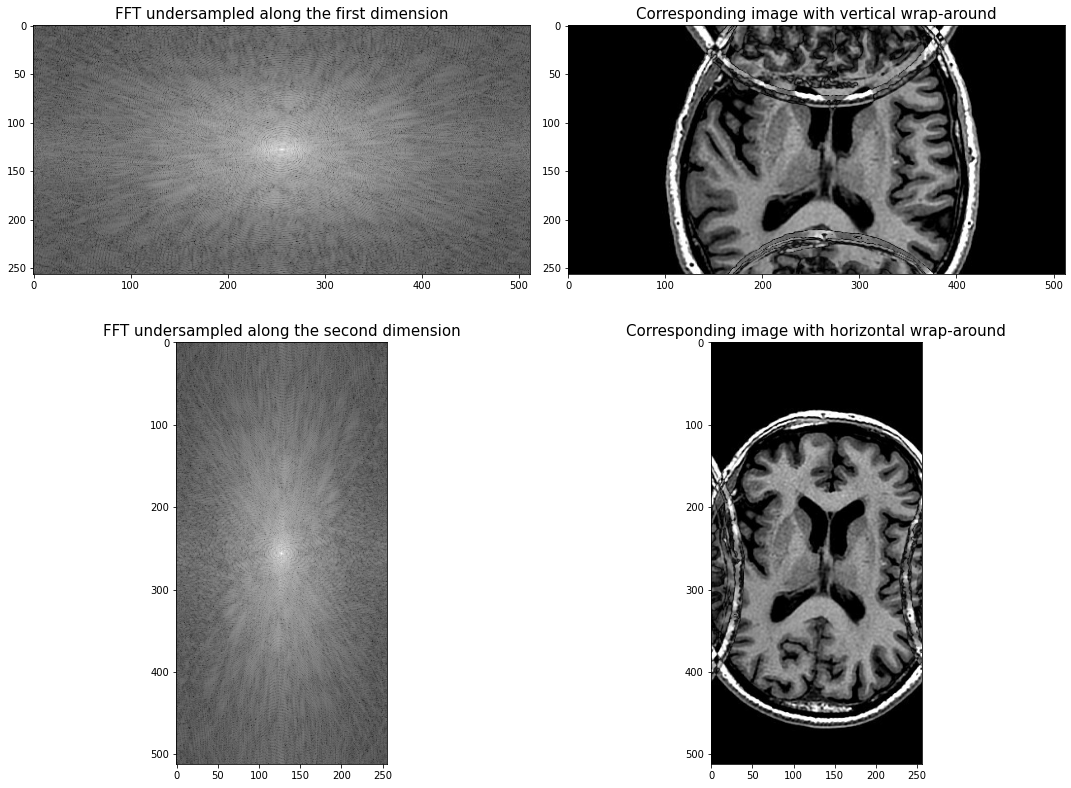

In [33]:
brain_FFT_undersampled_1 = fft2(ifftshift(brain_image))[1::2,:] # Undersample the FFT along the first dimension (1 line out of 2)
brain_FFT_undersampled_2 = fft2(ifftshift(brain_image))[:,1::2] # Undersample the FFT along the second dimension (1 column out of 2)

plt.figure(figsize=[15, 12], tight_layout=dict({'h_pad':0}))
plt.subplot(221); plt.imshow(np.log(np.abs(fftshift(brain_FFT_undersampled_1)))); plt.title("FFT undersampled along the first dimension", fontsize=15)
plt.subplot(222); plt.imshow(np.abs(fftshift(ifft2(brain_FFT_undersampled_1)))); plt.title("Corresponding image with vertical wrap-around", fontsize=15)
plt.subplot(223); plt.imshow(np.log(np.abs(fftshift(brain_FFT_undersampled_2)))); plt.title("FFT undersampled along the second dimension", fontsize=15)
plt.subplot(224); plt.imshow(np.abs(fftshift(ifft2(brain_FFT_undersampled_2)))); plt.title("Corresponding image with horizontal wrap-around", fontsize=15)
plt.show()

**How do we get rid of the wrap-around artifact ?**

- Increasing the FOV so it contains the whole object (increases image resolution or scanning time),
- Swapping the phase and frequency encoding directions (for longitudinal objects) so that larger dimensions are along the frequency encoding direction,
- Using surface coils that do not detect the signal outside of the FOV,
- Applying saturation bands in order to null the signal outside of the FOV,
- Oversampling in the phase-direction (increase FOV, increase phase encoding steps, reduce number of excitations, only reconstruct center of FOV).

## Nyquist N/2 Ghosting

Also known as: **Three Brains Artifact** (in head RI.)

This artifact is commonly observed in EPI sequences (where the k-space is filled with a zig-zag trajectory). This is generally caused by eddy current-induced phase shifts between 2 alternate k-space lines and results in an aliased imaged shifted by N/2 pixels in the phase-encoding direction. 

These artifacts can sometimes also be the result of patient motion, receiver filter asymmetry, suceptibility variations, poor shimming, oblique slices (with unsynchronized gradient switches) and any other phenomenom that could induce phase shifts in the k-space.

<br>
<figure><center>
  <div style="display: table;">
      <div style="  float:left ;width: 33.33%;">
          <img src="./utils/images/Nyquist1.jpg" alt="Nyquist ghost example 1" style="height:250px">
      </div>
      <div style="  float: left;width: 33.33%;">
          <img src="./utils/images/Nyquist2.jpg" alt="Nyquist ghost example 2"  style="height:250px">
      </div>
      <div style="  float: left;width: 33.33%;">
          <img src="./utils/images/Nyquist3.jpg" alt="Nyquist ghost example 3"  style="height:250px">
      </div>
 </div>
 <figcaption> <i>Examples of Nyquist N/2 ghosting</i> </figcaption></center>
</figure>

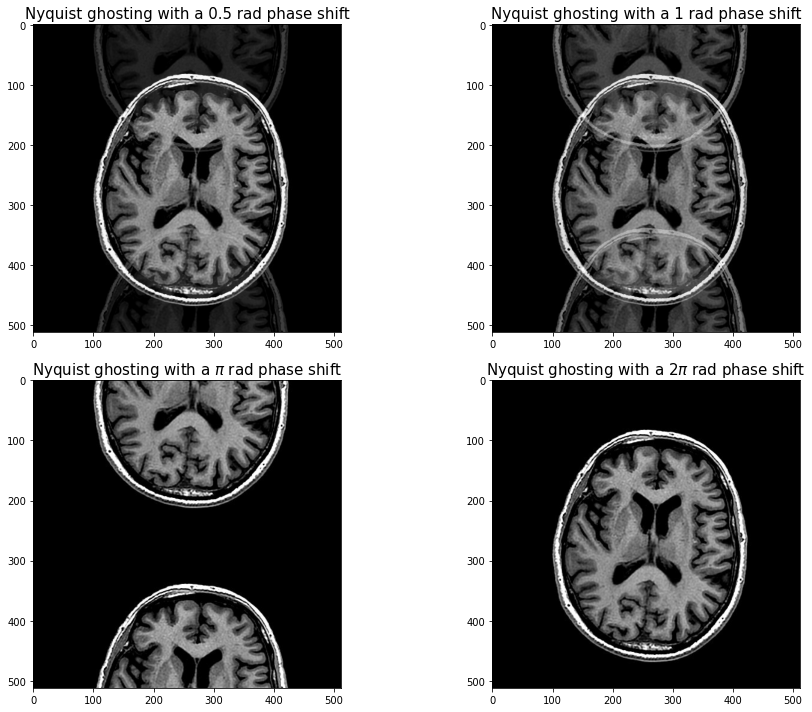

In [34]:
# Function to apply Nyquist Ghosting to an image. The phase shift to apply must be specified
def nyquist_ghost(image, shift):
    FFT_ghosted = fft2(ifftshift(image))
    shifted_phase = np.angle(FFT_ghosted)
    shifted_phase[::2,:] = np.angle(FFT_ghosted)[::2,:] + shift # Add the phase shift to 1 line out of 2
    return np.abs(fftshift(ifft2(np.abs(FFT_ghosted)*np.exp(1j*shifted_phase)))) # Return the ghosted image (shifted) 

plt.figure(figsize=[14, 10],  tight_layout=dict({'w_pad':1}))
plt.subplot(221); plt.imshow(nyquist_ghost(brain_image, 0.5)); plt.title("Nyquist ghosting with a 0.5 rad phase shift", fontsize=15)
plt.subplot(222); plt.imshow(nyquist_ghost(brain_image, 1)); plt.title("Nyquist ghosting with a 1 rad phase shift", fontsize=15); 
plt.subplot(223); plt.imshow(nyquist_ghost(brain_image, np.pi)); plt.title("Nyquist ghosting with a $\pi$ rad phase shift", fontsize=15)
plt.subplot(224); plt.imshow(nyquist_ghost(brain_image, 2*np.pi)); plt.title("Nyquist ghosting with a $2\pi$ rad phase shift", fontsize=15)
plt.show()

**How to eliminate/reduce Nyquist Ghosting ?**

The different applicable methods depend on what causes the Nyquist ghosting.

- Lowering the phase encoding resolution,
- Reducing the echo train length of the EPI sequence,
- Using parallel imaging
- Re-shimming...

## Gibbs artifact

Also known as: **truncation**, **ringing** or **spectral leakage artifacts**.

Gibbs artifacts manifests themselves by the apparition of ripple around high contrast interfaces. 

As you might have seen in the **Square-signal decomposition interactive animation**, approximating a square signal without enough sinusoids results in the apparition of "ripples" at the top of the square signal. In the image domain, having a high intensity region right beside a low intensity region can be assimilated to a square signal and thus requires an infinite number of k-space samples in order to be perfectly reconstructed. As we are limited in the number of samples acquired in the Fourier domain, we might not have enough information to correctly reconstruct this high contrast interface during the inverse Fourier transform process. This is why ripples might appear around highly contrasted regions.

<br>
<figure><center>
  <div style="display: table;">
      <div style="  float:left ;width: 33.33%;">
          <img src="./utils/images/Gibbs1.jpg" alt="Gibbs artifact example 1" style="height:250px">
      </div>
      <div style="  float: left;width: 33.33%;">
          <img src="./utils/images/Gibbs2.jpg" alt="Gibbs artifact example 2"  style="height:250px">
      </div>
      <div style="  float: left;width: 33.33%;">
          <img src="./utils/images/Gibbs3.jpg" alt="Gibbs artifact example 3"  style="height:250px">
      </div>
 </div>
 <figcaption> <i>Examples of Gibbs artefacts</i> </figcaption></center>
</figure>

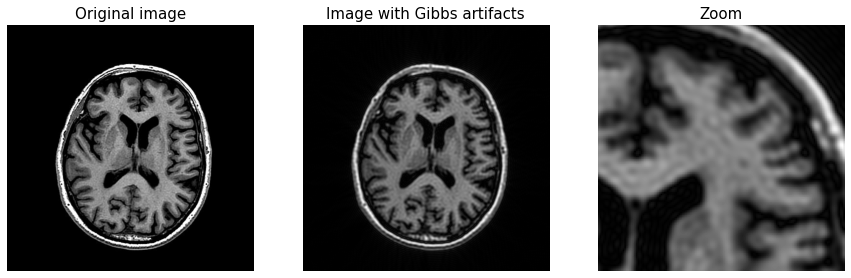

In [35]:
brain_FFT_gibbs = fftshift(fft2(ifftshift(brain_image)))

for i in range(512):
    for j in range(512):
        if ((i-256)**2+(j-256)**2) > 5000:
            brain_FFT_gibbs[i, j] = 0 # Removing FFT values on the edges to simulate a lack of data
            
brain_image_gibbs = np.abs(fftshift(ifft2(ifftshift(brain_FFT_gibbs))))
    
plt.figure(figsize=[15,5])
plt.subplot(131); plt.imshow(brain_image); plt.title('Original image', fontsize=15); plt.axis('off')
plt.subplot(132); plt.imshow(brain_image_gibbs); plt.title('Image with Gibbs artifacts', fontsize=15); plt.axis('off')
plt.subplot(133); plt.imshow(brain_image_gibbs[100:250, 250:400]); plt.title('Zoom', fontsize=15); plt.axis('off'); plt.axis('off')
plt.show()

**What can be done to reduce the Gibbs artifacts** ?

- Reducing the Field of view,
- Increasing the number of encoding steps, 
- Filtering the k-space (e.g. with a Hamming window) before processing,
- Supress signal from tissues involved in high-contrast boundaries (e.g. fat suppression).

## Zipper Artifact

These artifacts occur when external RF sources (radio, light, surrounding electronic devices...) interfere with the scanner's receive chain. When inverse transformed, this additional signal results in linear artifacts perpendicular to the frequency encoding direction.

The position of the artifact on the frequency encoding direction will depend on the frequency of the external RF signal

<br>
<figure><center>
  <div style="display: table;">
      <div style="  float:left ;width: 33.33%;">
          <img src="./utils/images/zipper1.jpg" alt="Zipper artifact example 1" style="height:250px">
      </div>
      <div style="  float: left;width: 33.33%;">
          <img src="./utils/images/zipper2.jpg" alt="Zipper artifact example 2"  style="height:250px">
      </div>
      <div style="  float: left;width: 33.33%;">
          <img src="./utils/images/zipper3.jpg" alt="Zipper artifact example 3"  style="height:250px">
      </div>
 </div>
 <figcaption> <i>Examples of Zipper artefacts</i> </figcaption></center>
</figure>

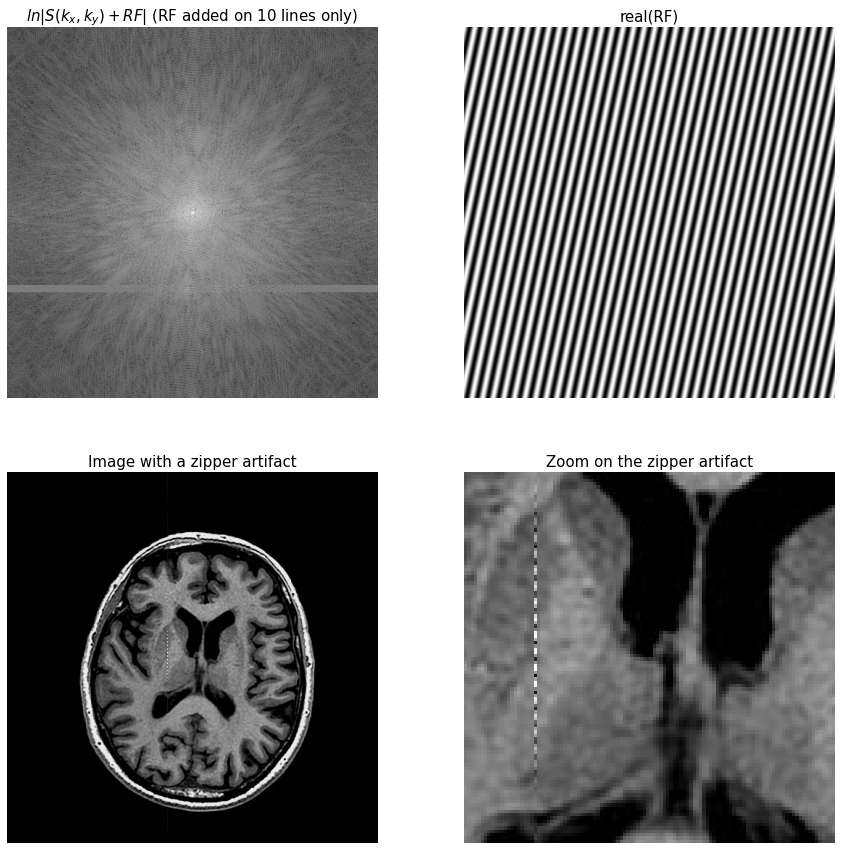

In [36]:
brain_FFT_zipper = fft2(ifftshift(brain_image))

# Defining an external complex RF signal and shaping it as the image to mimic k-space acquisition
RF_external = 8000*np.exp(1j*(np.linspace(0, 112640, 512*512))) # Parameters are chosen to result in a visible artifact
RF_external = np.reshape(RF_external, (512,512))

# Adding RF signal to 10 lines of k-space 
brain_FFT_zipper[100:110,:]  += RF_external[100:110,:]

brain_image_zipper = np.abs(fftshift(ifft2(brain_FFT_zipper)))
plt.figure(figsize=[15,15])
plt.subplot(221); plt.imshow(np.log(np.abs(fftshift(brain_FFT_zipper)))); plt.title("$ln|S(k_x, k_y)+RF|$ (RF added on 10 lines only)", fontsize=15); plt.axis('off')
plt.subplot(222); plt.imshow(np.real(RF_external)); plt.title("real(RF)", fontsize=15), plt.axis('off')
plt.subplot(223); plt.imshow(brain_image_zipper); plt.title("Image with a zipper artifact", fontsize=15); plt.axis('off')
plt.subplot(224); plt.imshow(brain_image_zipper[200:312,200:312]); plt.title("Zoom on the zipper artifact", fontsize=15), plt.axis('off')
plt.show()

**How to limit the zipper artifacts**:

- Prevent the exteral RF waves to reach the scanner room by improving the RF-shielding,
- Remove non-essential electronic devices from the scanning room.

## Ressources and references

- [Questions and answers in MRI: MR Artifacts](http://mriquestions.com/hellipmr-artifacts.html)
- [Radiopaedia: MRI artifacts](https://radiopaedia.org/articles/mri-artifacts-1?lang=us)
- [Wikipedia: Joseph Fourier](https://en.wikipedia.org/wiki/Joseph_Fourier)